In [162]:
import datautil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import networkx as nx
from collections import Counter

In [4]:
projects = datautil.select_projects_from_libraries_io()
libraries = datautil.select_libraries_from_libraries_io()
lib_names = set(libraries["name"])
rules = datautil.select_rules(lib_names)
dep_changes = datautil.select_dependency_changes_all()
migrations = datautil.select_migrations()

print(f"{len(set(migrations.fromLib))} source libs, {len(set(migrations.toLib))} target libs, {len(set(migrations.fromLib) | set(migrations.toLib))} total libs")
print(f"{len(set(migrations.startCommit) | set(migrations.endCommit))} total commits")
print(f"{len(set(migrations.repoName))} repositories")
print(f"{len(set(zip(migrations.fromLib, migrations.toLib)))} migration rules")

407 from libs, 621 to libs, 788 total libs
3215 total commits
1616 repositories
1257 migration rules


In [41]:
valid_projects = dep_changes[dep_changes.lib2.isin(set(migrations.fromLib))].project
projects = projects[projects.nameWithOwner.isin(valid_projects)]
dep_changes = dep_changes[dep_changes.project.isin(valid_projects)]
print(f"{len(projects)} projects, {len(dep_changes)} dep changes")

18074 projects, 3324371 dep changes


In [21]:
cls2 = pd.read_excel("data/cls2.xlsx")
lib2category = dict(zip(cls2.package, cls2.adjusted_category))

In [137]:
rules["fromLibCategory"] = rules.fromLib.map(lambda x: lib2category[x])
rules["toLibCategory"] = rules.toLib.map(lambda x: lib2category[x])
rules["numRepositories"] = [len(set(migrations[(migrations.fromLib == from_lib) & (migrations.toLib == to_lib)].repoName))
                            for from_lib, to_lib in zip(rules.fromLib, rules.toLib)]
rules.head()

,fromLib,toLib,fromLibCategory,toLibCategory,numRepositories
0,ant:ant,org.apache.ant:ant,Build,Build,15
1,ant:ant,org.apache.ant:ant-apache-regexp,Build,Build,1
2,ant:ant,org.apache.ant:ant-junit,Build,Build,1
3,ant:ant,org.apache.ant:ant-nodeps,Build,Build,3
4,ant:ant,org.apache.ant:ant-trax,Build,Build,1


Counter({'Webservice': 184, 'Logging': 162, 'JSON': 160, 'Testing': 159, 'Other': 158, 'Database': 48, 'XML': 43, 'Persistence': 31, 'Dependency Injection': 27, 'Bytecode': 27, 'HTTP Clients': 20, 'JDBC Pools': 19, 'Metrics': 17, 'Command Line': 16, 'Build': 15})


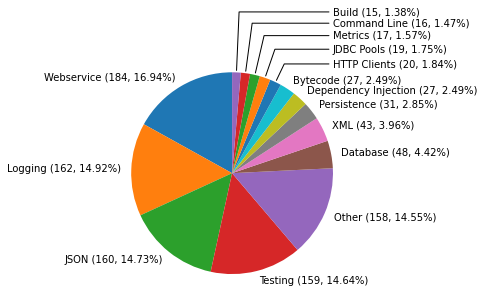

In [125]:
catdis = Counter(rules[rules.fromLibCategory == rules.toLibCategory].fromLibCategory)
for key in list(catdis.keys()):
    if key != "other" and catdis[key] < 13:
        catdis["Other"] += catdis[key]
        del catdis[key]
print(catdis)
data = sorted(catdis.items(), key=lambda x: -x[1])
labels = [f"{x[0]} ({x[1]}, {100 * x[1] / sum(catdis.values()):.2f}%)" for x in data]
fig, ax = plt.subplots(figsize=(4,4))
patches, texts = ax.pie([x[1] for x in data], labels=labels[0:10] + [""] * (len(labels) - 10),
        shadow=False, startangle=90, labeldistance=1.1, pctdistance=0.8)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i in range(-5, 0):
    p = patches[i]
    ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1*np.sign(x), (1.7 + 0.1 * i) *y),
                horizontalalignment=horizontalalignment, **kw)
fig.savefig("plots/migration_category.pdf", bbox_inches="tight")

In [192]:
web_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Webservice")]
print(f"{len(web_rules)} rules, {len(set(web_rules.fromLib) | set(web_rules.toLib))} libraries")

184 rules, 116 libraries


In [193]:
logging_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Logging")]
print(f"{len(logging_rules)} rules, {len(set(logging_rules.fromLib) | set(logging_rules.toLib))} libraries")

162 rules, 36 libraries


In [194]:
json_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "JSON")]
print(f"{len(json_rules)} rules, {len(set(json_rules.fromLib) | set(json_rules.toLib))} libraries")

160 rules, 46 libraries


In [195]:
test_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Testing")]
print(f"{len(test_rules)} rules, {len(set(test_rules.fromLib) | set(test_rules.toLib))} libraries")

159 rules, 82 libraries


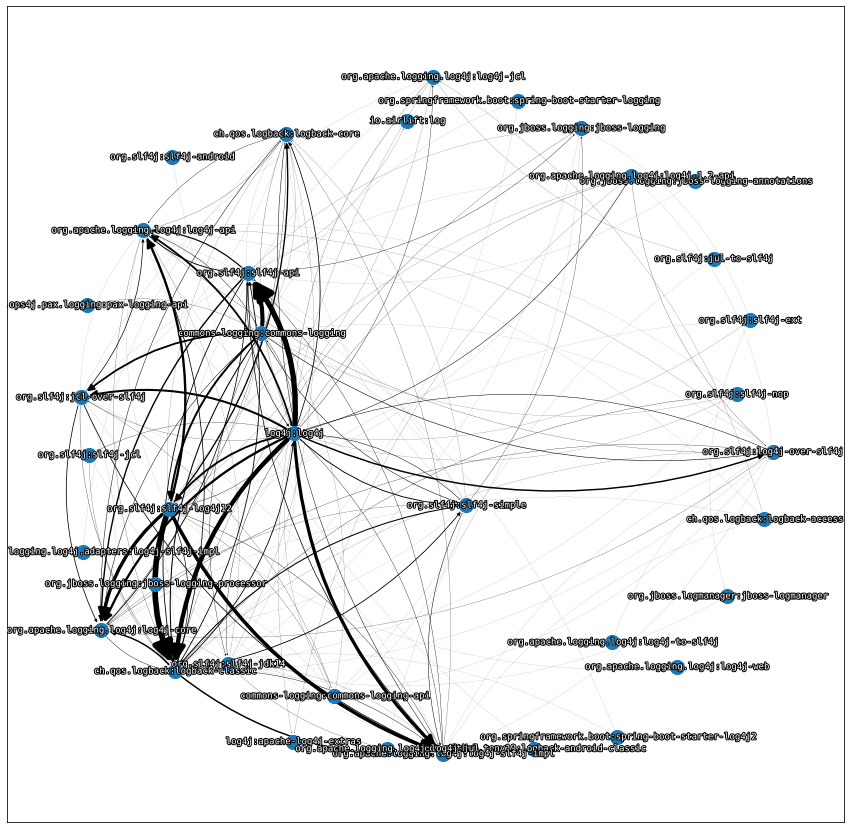

In [217]:
def visualize_migration_graph(subrules, outfile, k):
    migration_graph = nx.DiGraph()
    migration_graph.add_nodes_from(set(subrules.fromLib) | set(subrules.toLib))
    for idx, rule in subrules.iterrows():
        migration_graph.add_edge(rule.fromLib, rule.toLib, weight=rule.numRepositories)
    
    fig, ax = plt.subplots(figsize=(15,15))
    nodes = migration_graph.nodes()
    edges = migration_graph.edges()

    pos = nx.spring_layout(migration_graph, k)  # positions for all nodes
    nx.draw_networkx_nodes(migration_graph, pos, node_size=200)
    for i, edge in enumerate(edges):
        weight = migration_graph.edges[edge]["weight"]
        nx.draw_networkx_edges(migration_graph, pos, edgelist=[edge], 
                           arrows=True, connectionstyle="arc3,rad=0.2",
                           width=0.07*weight,
                           arrowsize=int(0.5*weight) + 1)

    text_items = nx.draw_networkx_labels(migration_graph, pos, font_size=9, font_family="monospace", font_color="white")
    for text in text_items.values():
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
        
    fig.savefig(outfile, bbox_inches="tight")
visualize_migration_graph(logging_rules, "plots/graph-logging.pdf", k=4)

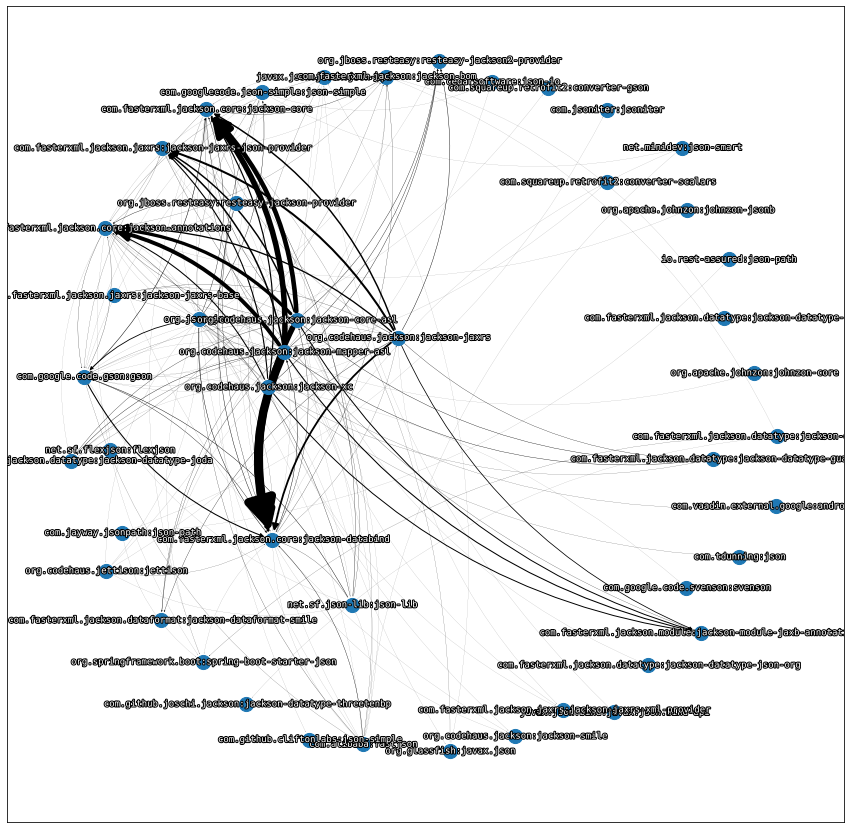

In [219]:
visualize_migration_graph(json_rules, "plots/graph-json.pdf", k=3)

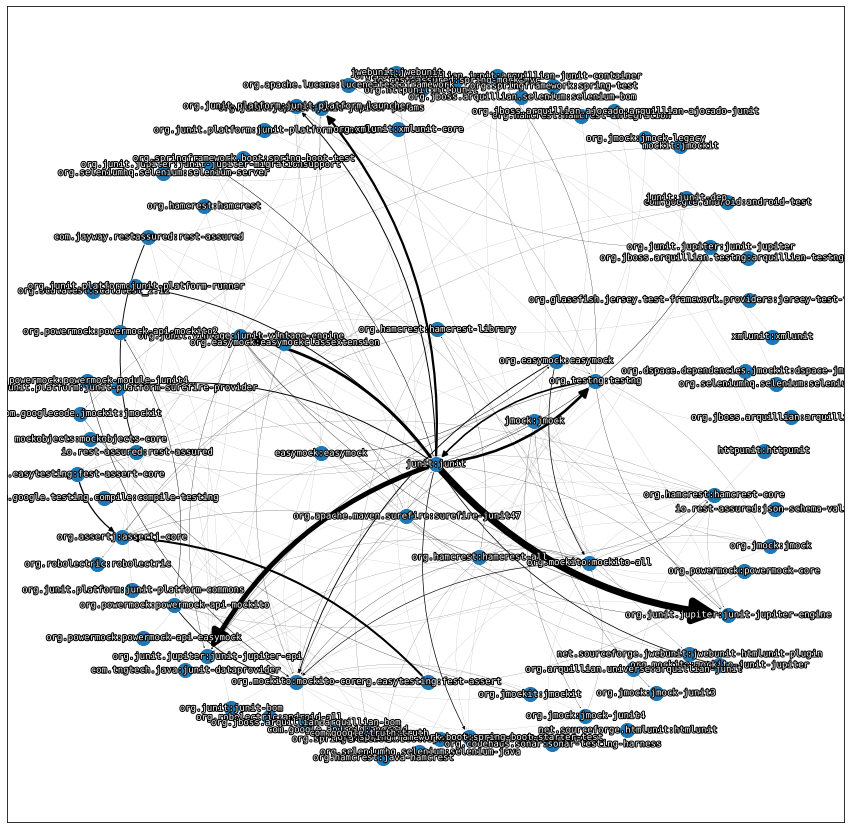

In [221]:
visualize_migration_graph(test_rules, "plots/graph-test.pdf", k=2)

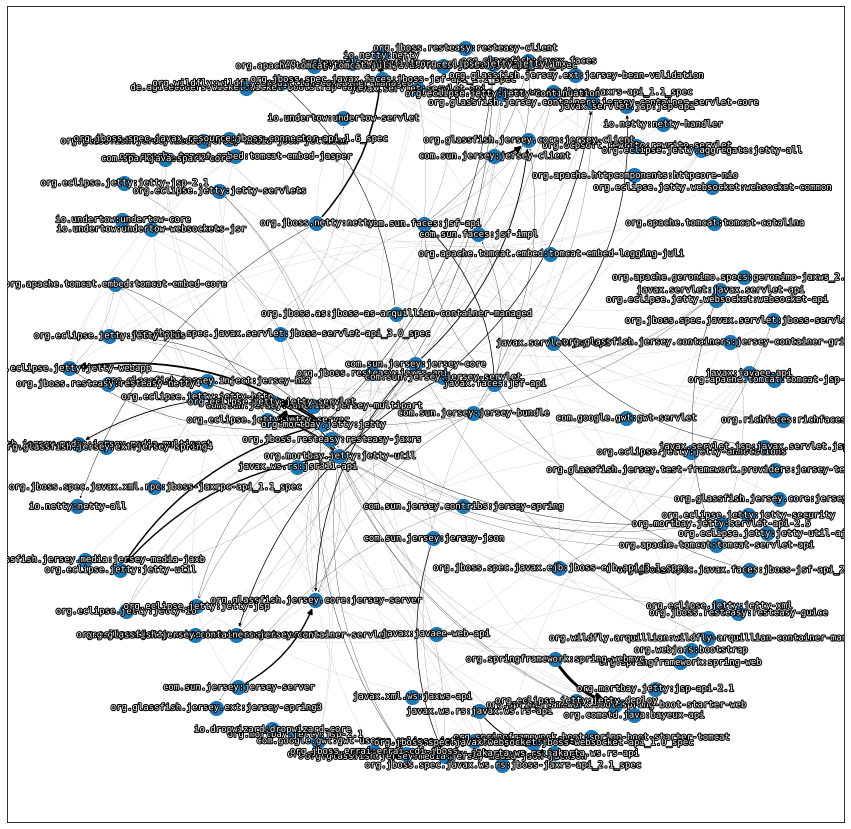

In [223]:
visualize_migration_graph(web_rules, "plots/graph-web.pdf", k=1)